# Market Regime Forecasting with LightGBM  
  
There are two parts in this notebook: 

**1. Regime Prediction using Hidden Markov model-generated log-probabilities**  

* Due to the persistence of HiddenMarkov("HMM") hidden states (see notebook on `Market Regime Forecasting with Hidden Markov`), there might be some autoregressive component worth modeling and predicting for. By using the log-probabilities generated by HMM Static-Window model for the bear regime as an input feature, we created rolling timeseries features that are used to predict the bull/bear regime one-step ahead and multi-steps ahead.  
* As with other notebooks, the training period is between 1993-2009 and the testing period is between 2010-2023/1. 
* The result showed that there is reasonable predictive accuracy for one-step ahead forecasts but extremely inaccurate for the multi-steps forecast.  
* Hence, for backtesting purposes, we will just be using the regime forecasts as generated by the One-Step Ahead model for the period 2018-2023/1 to evaluate its actual trading profitability.  
    
**2. Regime Prediction using timeseries features derived from 1-Month returns**  
  
* This section attempts to use just one initial feature input `1M_RETURNS` to derive a large selection of timeseries features from which the most informative ones will be used to train and predict the current regime state.  
* The training period is between 1993-2009 and the testing period is between 2010-2023/1. Backtesting period is between 2018-2023/1.
* While at face value, its prediction of bull/bear regimes roughly matches the states as predicted by the same HMM model, its actual backtesting profitability is abysmal due to a significant number of false positives/false negatives.  
  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from warnings import simplefilter

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

import pyfolio as pyf

simplefilter("ignore")

from sklearn.model_selection import train_test_split

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plot_x_size = 15
plot_y_size = 2

import lightgbm as lgb

from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# Read historical price data for ticker
filepath = f'./datasets/asset_train.csv'
train_df = pd.read_csv(filepath)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df.set_index('Date', inplace=True)

test_df = pd.read_csv(f"./datasets/asset_test.csv")
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df.set_index('Date', inplace=True)

In [3]:
train_df

,ADJ CLOSE,ADX,CCI,RSI,MASS_INDEX,DONCHIAN,1M_RETURNS,3M_RETURNS,regime,bear_proba
Date,,,,,,,,,,
1993-05-03,25.553581,26.154337,-15.150025,48.976197,25.622208,0.550000,-1.596101e-02,0.013298,1,3.500751e-33
1993-05-04,25.643688,25.730673,40.596206,51.633782,25.548165,0.633333,8.504950e-03,0.009690,1,1.666501e-03
1993-05-05,25.715754,24.945331,69.905533,53.710930,25.560623,0.700000,6.346364e-03,0.010387,1,2.940693e-03
1993-05-06,25.625660,24.362171,57.616893,50.775484,25.489994,0.616667,5.657712e-03,-0.003685,1,1.383830e-03
1993-05-07,25.571592,24.112678,47.863248,49.043558,25.361100,0.566667,2.220446e-16,-0.009930,1,8.280503e-04
...,...,...,...,...,...,...,...,...,...,...
2009-12-24,87.790802,9.905031,133.021101,60.998894,23.205780,0.973215,1.888073e-02,0.076903,0,9.999953e-01
2009-12-28,87.978088,10.302690,133.748563,62.061832,23.060617,0.944559,1.747910e-02,0.084987,0,9.999937e-01
2009-12-29,87.853203,10.701450,123.007401,60.870736,22.962950,0.882793,3.281888e-02,0.064390,0,9.999657e-01


In [4]:
def interpret_dftest(dftest):
    """
    Interprets output of Dickey-Fuller test for stationarity
    
    dftest: adfuller(time_series)
    """
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic', 'p-value'])
    return dfoutput

In [5]:
# Check stationarity of our target col first
interpret_dftest(adfuller(train_df['bear_proba']))

# Since p-value < alpha of 0.01, we will conclude that the regime_logit series is likely stationary
# No further differencing needed

Test Statistic   -1.132055e+01
p-value           1.177082e-20
dtype: float64

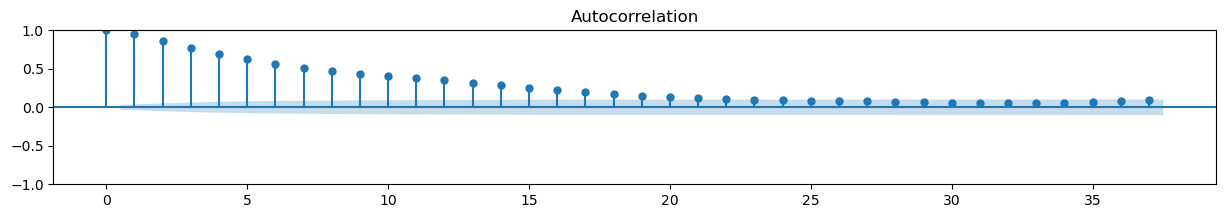

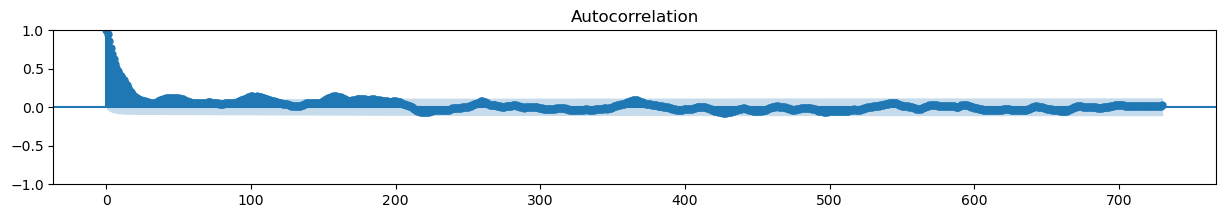

In [6]:
# Check for autocorrelation and seasonality
plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]

plot_acf(train_df['bear_proba'])
plt.show()

plot_acf(train_df['bear_proba'], lags = 730, use_vlines = True)
plt.show()

# ACF plot suggests the log probabilities of a bear market are positively correlated up to a lag of approximately 2 weeks
# No signs of seasonality within the time series

## 1. Regime Prediction using Hidden Markov model-generated log-probabilities

### 1.1 Making a One-Step Prediction

We first try to make a simple one-step prediction to see if LGBM can be used to predict HMM regime labels on a forward basis.  

In order to train the model, we will create a rolling timeseries of the last 750 daily rows of bear-market log-probabilities for every single day in the training period between 1993-2007. The trained LGBM will then be used to test on the data for the validation period between 2008-2009.   

In [7]:
# Transform bear_proba series into a supervised learning dataset first

train_bear_proba = train_df['bear_proba']   #1993-2009
test_bear_proba = test_df['bear_proba']     #2010-2023/1


# Create X, Y as our supervised learning set
def create_xy(series, window_size, prediction_horizon, shuffle=False):
    x = []
    y = []
    for i in range(0, len(series)):
        if len(series[(i + window_size):(i + window_size + prediction_horizon)]) < prediction_horizon:
            break
        x.append(series[i:(i + window_size)])
        y.append(series[(i + window_size):(i + window_size + prediction_horizon)])
    x = np.array(x)
    y = np.array(y)
    return x, y


In [8]:
train_bear_proba.shape

(4200,)

In [9]:
# Splitting the train_df set into train+val sets

### HYPERPARAMETERS ###
window_size = 750       # lookback past 3 years of daily data for model fitting
prediction_horizon = 1  # horizon=1 for making one-step ahead forecast

### TRAIN VAL SPLIT ### 
val_size = 500
split_time = len(train_bear_proba) - val_size

train_series = train_bear_proba[:split_time]
val_series = train_bear_proba[split_time - window_size:]
test_series = test_bear_proba

train_X, train_y = create_xy(train_series, window_size, prediction_horizon)
val_X, val_y = create_xy(val_series, window_size, prediction_horizon)
test_X, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()  # flatten y series from 2D to 1D array
val_y = val_y.flatten()
test_y = test_y.flatten()

print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(val_y.shape)
print(test_X.shape)
print(test_y.shape)

(2950, 750)
(2950,)
(500, 750)
(500,)
(2540, 750)
(2540,)


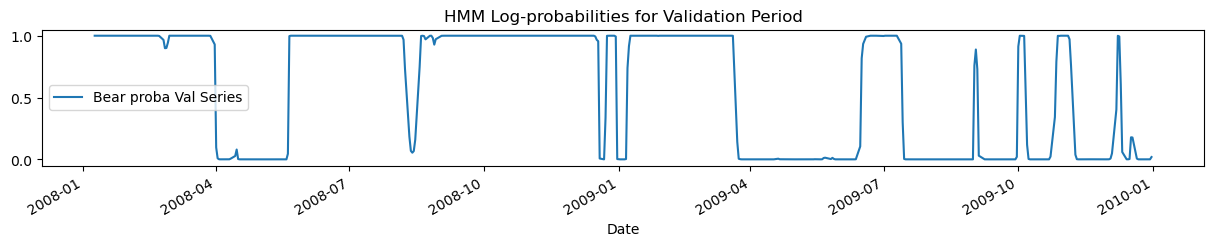

In [14]:
# Visualize bear proba for the val set
plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]

train_bear_proba[-val_size:].plot(label= 'Bear proba Val Series')
plt.title('HMM Log-probabilities for Validation Period')
plt.legend();

In [15]:
# Model Fitting
params = {
    'n_estimators':2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart',
    'n_jobs': -1,
}


model = lgb.LGBMRegressor(first_metric_only=True, **params)

model.fit(train_X, train_y,
         eval_metric = 'l1',
         eval_set = [(val_X, val_y)],
         #early_stopping_round=10,
         verbose=0)

LGBMRegressor(boosting_type='dart', first_metric_only=True, max_depth=4,
              n_estimators=2000, num_leaves=16)

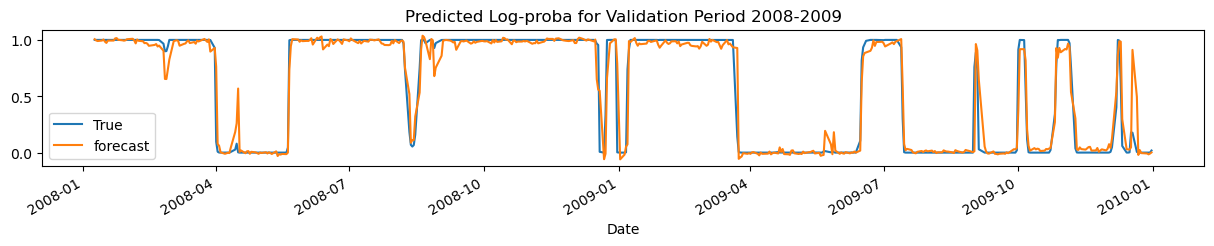

In [17]:
# Visualize the LightGBM's forecasts vs HiddenMarkov labels for the validation period
forecast = model.predict(val_X)
forecast_series = pd.Series(data=forecast, index=train_bear_proba[-val_size:].index)   # note first 750 rows of the val set has been used for prediction

plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]
train_bear_proba[-val_size:].plot(label='True')
plt.plot(forecast_series, label='forecast')
plt.title('Predicted Log-proba for Validation Period 2008-2009')
plt.legend();


# Predicting forward on a testing period of 2 years, model performed very well with very few False Positives (predicted bear regime when True label was bull)
# One-Step predictions are constantly made based on a rolling timeseries of the past 750 days
# This experiment showed that the autoregressive component of a bull/bear regime is very strong and has a tendency to persist

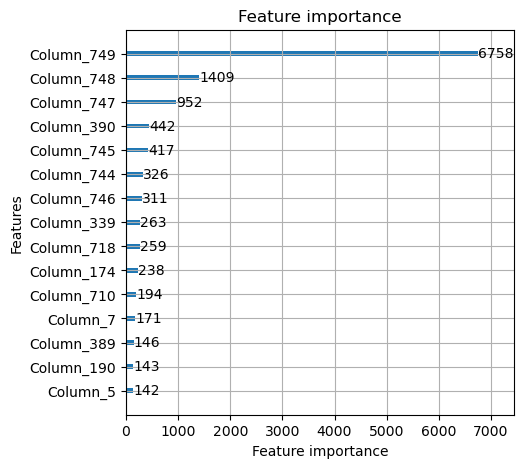

In [18]:
# Feature Importances
plt.rcParams['figure.figsize'] = [5, 5]

lgb.plot_importance(model, max_num_features=15, importance_type='split')
plt.show()

# Column 749 is yesterday's signal. What this means is that yesterday's input has the highest weight in predicting today's signal

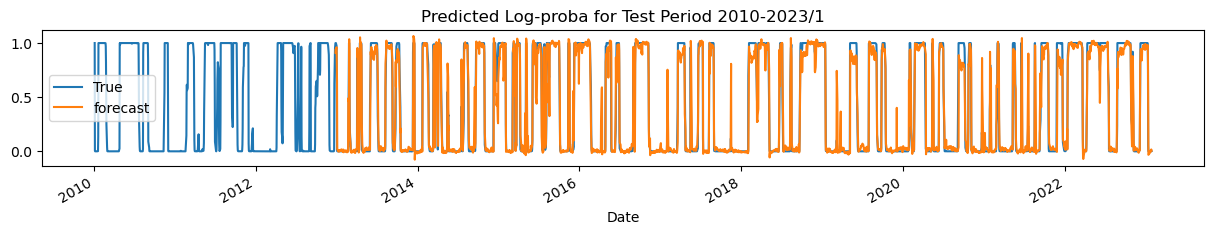

In [19]:
# Now predict on the test_df for the testing period 2010-2023/1
test_preds = model.predict(test_X)
test_preds_series = pd.Series(data=test_preds, index=test_bear_proba[window_size:].index)    # note first 750 rows of test period are used for prediction

plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]
test_bear_proba.plot(label='True')
plt.plot(test_preds_series, label='forecast')
plt.title('Predicted Log-proba for Test Period 2010-2023/1')
plt.legend();

In [41]:
for_backtest = test_preds_series.loc['2018':'2023'].copy().to_frame()
for_backtest.rename(columns={0:'pred_bear_proba'}, inplace=True)
for_backtest['regime'] = np.where(for_backtest['pred_bear_proba'] < 0.5, 1.0, 0.0)

# As the daily regime prediction is only made after the day's session has ended, the signals generated today are in fact for tomorrow's use
# So we need to shift all the regime preds by +1 period for backtesting on yesterday's signals, and not today's signals
for_backtest['regime'] = for_backtest['regime'].shift(1)
for_backtest.to_csv('regime_filter.csv', index=True)
for_backtest

,pred_bear_proba,regime
Date,,
2018-01-02,-0.010999,NaN
2018-01-03,-0.005816,1.0
2018-01-04,-0.004749,1.0
2018-01-05,-0.002519,1.0
2018-01-08,-0.008709,1.0
...,...,...
2023-01-23,0.001101,1.0
2023-01-24,-0.001570,1.0
2023-01-25,0.011193,1.0


### 1.2 Making Multi-Step Prediction


#### Recursive Forecasting
In recursive forecasting, we first train a one-step model then generate a multi-step forecast by recursively feeding our predictions back into the model.

In [21]:
params = {
    'n_estimators':2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart',
    'n_jobs': -1,
}


model_rs = lgb.LGBMRegressor(first_metric_only=True, **params)

model_rs.fit(train_X, train_y,
         eval_metric = 'l1',
         eval_set = [(test_X, test_y)],
         #early_stopping_round=10,
         verbose=0)

LGBMRegressor(boosting_type='dart', first_metric_only=True, max_depth=4,
              n_estimators=2000, num_leaves=16)

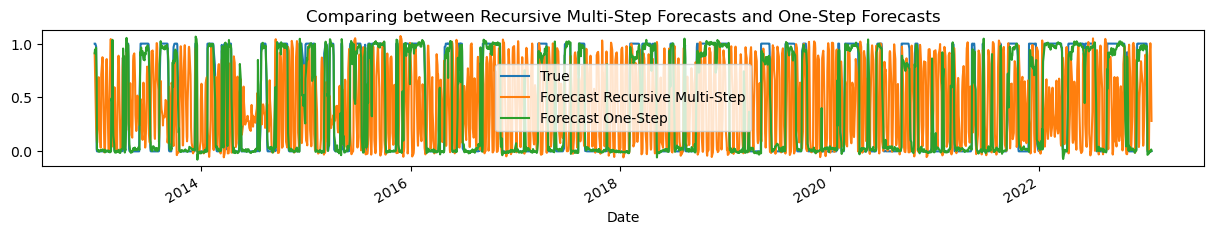

In [31]:
# Grab first row of test_X data first
recursive_X = test_X[0,:]   

forecast_ms = []
for i in range(test_X.shape[0]):
    pred = model_rs.predict(recursive_X.reshape((1, recursive_X.shape[0])))
    recursive_X = np.append(recursive_X[1:], pred)   # drop first value and append pred to last index pos to form a recursive series
    forecast_ms.append(pred)
    
    
forecast_ms_rec = np.asarray(forecast_ms).flatten()
forecast_os = model_rs.predict(test_X)

forecast_ms_rec_series = pd.Series(data=forecast_ms_rec, index=test_bear_proba[window_size:].index)
forecast_os_series = pd.Series(data=forecast_os, index=test_bear_proba[window_size:].index)


plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]

test_bear_proba[window_size:].plot(label = 'True')
plt.plot(forecast_ms_rec_series, label = 'Forecast Recursive Multi-Step')
plt.plot(forecast_os_series, label = 'Forecast One-Step')
plt.title('Comparing between Recursive Multi-Step Forecasts and One-Step Forecasts')
plt.legend();


# Forecasting for multi-step using a recursive basis is very bad with a lot of False Positives and False Negatives
# In the first place, our True labels are predicted labels in itself from the HiddenMarkov modeling so predicting on top of predicted labels may not be such a great idea

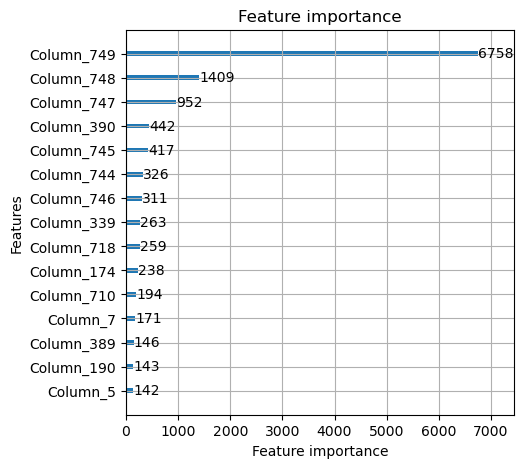

In [30]:
# Feature Importances
plt.rcParams['figure.figsize'] = [5, 5]

lgb.plot_importance(model, max_num_features=15, importance_type='split')
plt.show()

# Column 749 is yesterday's signal. What this means is that yesterday's input has the highest weight in predicting today's signal

## 2. Regime Prediction using timeseries features derived from 1M_RETURNS

### Simplifying the Initial Feature Inputs

Having to gather several feature inputs' data before predicting the market regime is a troublesome process. Here, I attempt to simplify the requirements to just one observable feature `1M_RETURNS`. With just the most recent 20 periods' worth of `1M_RETURNS`, we can derive an informative set of time series features using `tsfresh` package which can then be used by the trained LightGBM model to predict the current state of the market.

In [43]:
# Select just one feature '1M_RETURNS'
asset_inputs = train_df[['1M_RETURNS']].copy()
asset_inputs['symbol'] = 'SPY'
asset_inputs['date'] = train_df.index

# Create a set of training data samples by rolling a window of 20 periods over the column 1M_RETURNS (windows<5 days are disregarded)
asset_rolled = roll_time_series(asset_inputs, column_sort='date', column_id='symbol', max_timeshift=20, min_timeshift=5)


Rolling: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


In [44]:
asset_rolled

,1M_RETURNS,symbol,date,id
0,-1.596101e-02,SPY,1993-05-03,"(SPY, 1993-05-10 00:00:00)"
1,8.504950e-03,SPY,1993-05-04,"(SPY, 1993-05-10 00:00:00)"
2,6.346364e-03,SPY,1993-05-05,"(SPY, 1993-05-10 00:00:00)"
3,5.657712e-03,SPY,1993-05-06,"(SPY, 1993-05-10 00:00:00)"
4,2.220446e-16,SPY,1993-05-07,"(SPY, 1993-05-10 00:00:00)"
...,...,...,...,...
87970,1.888073e-02,SPY,2009-12-24,"(SPY, 2009-12-31 00:00:00)"
87971,1.747910e-02,SPY,2009-12-28,"(SPY, 2009-12-31 00:00:00)"
87972,3.281888e-02,SPY,2009-12-29,"(SPY, 2009-12-31 00:00:00)"
87973,2.897709e-02,SPY,2009-12-30,"(SPY, 2009-12-31 00:00:00)"


In [47]:
# Extract Features
# At each id, time series features will be extracted from the series of 1M_RETURNS

extraction_settings = ComprehensiveFCParameters()

X = extract_features(asset_rolled.drop('symbol', axis=1),
                     column_id='id', column_sort='date', column_value='1M_RETURNS',
                     impute_function=impute)


y = train_df['bear_proba'][5:]  # first five rows have discarded for training so we will need to discard likewise for the target column 
                     

Feature Extraction: 100%|██████████| 20/20 [02:06<00:00,  6.31s/it]


In [48]:
X.head()

1M_RETURNS__variance_larger_than_standard_deviation  \
SPY 1993-05-10                                                0.0     
    1993-05-11                                                0.0     
    1993-05-12                                                0.0     
    1993-05-13                                                0.0     
    1993-05-14                                                0.0     

                1M_RETURNS__has_duplicate_max  1M_RETURNS__has_duplicate_min  \
SPY 1993-05-10                            0.0                            0.0   
    1993-05-11                            0.0                            0.0   
    1993-05-12                            0.0                            0.0   
    1993-05-13                            0.0                            0.0   
    1993-05-14                            0.0                            0.0   

                1M_RETURNS__has_duplicate  1M_RETURNS__sum_values  \
SPY 1993-05-10                        0.0                0.008077   
    1993-05-11                        0.0                0.001814   
    1993-05-12                        0.0               -0.007909   
    1993-05-13                        0.0               -0.028076   
    1993-05-14                        0.0               -0.048939   

                1M_RETURNS__abs_energy  1M_RETURNS__mean_abs_change  \
SPY 1993-05-10                0.000412                     0.007300   
    1993-05-11                0.000451                     0.007715   
    1993-05-12                0.000546                     0.007107   
    1993-05-13                0.000952                     0.007525   
    1993-05-14                0.001388                     0.006766   

                1M_RETURNS__mean_change  \
SPY 1993-05-10                 0.003898   
    1993-05-11                 0.001616   
    1993-05-12                 0.000891   
    1993-05-13                -0.000526   
    1993-05-14                -0.000545   

                1M_RETURNS__mean_second_derivative_central  \
SPY 1993-05-10                                   -0.002617   
    1993-05-11                                   -0.003426   
    1993-05-12                                   -0.002327   
    1993-05-13                                   -0.002494   
    1993-05-14                                   -0.001573   

                1M_RETURNS__median  ...  1M_RETURNS__fourier_entropy__bins_5  \
SPY 1993-05-10        4.593312e-03  ...                             0.693147   
    1993-05-11        3.528911e-03  ...                             1.039721   
    1993-05-12        1.764456e-03  ...                             1.332179   
    1993-05-13        2.220446e-16  ...                             0.950271   
    1993-05-14       -3.131595e-03  ...                             0.450561   

                1M_RETURNS__fourier_entropy__bins_10  \
SPY 1993-05-10                              1.039721   
    1993-05-11                              1.386294   
    1993-05-12                              1.609438   
    1993-05-13                              1.332179   
    1993-05-14                              0.867563   

                1M_RETURNS__fourier_entropy__bins_100  \
SPY 1993-05-10                               1.386294   
    1993-05-11                               1.386294   
    1993-05-12                               1.609438   
    1993-05-13                               1.609438   
    1993-05-14                               1.791759   

                1M_RETURNS__permutation_entropy__dimension_3__tau_1  \
SPY 1993-05-10                                           1.039721     
    1993-05-11                                           1.332179     
    1993-05-12                                           1.242453     
    1993-05-13                                           1.153742     
    1993-05-14                                           1.073543     

                1M_RETURNS__permutation_entrop

In [49]:
X.shape   # Original dataset had 4,200 rows. Disregarding the first 5 rows due to the rolling window requirement, we now have 4,195 rows of new time-features to fit our model on

(4195, 783)

In [50]:
# Reindex to a dateIndex
X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
X.index.name = 'last_date'
X.head()

,1M_RETURNS__variance_larger_than_standard_deviation,1M_RETURNS__has_duplicate_max,1M_RETURNS__has_duplicate_min,1M_RETURNS__has_duplicate,1M_RETURNS__sum_values,1M_RETURNS__abs_energy,1M_RETURNS__mean_abs_change,1M_RETURNS__mean_change,1M_RETURNS__mean_second_derivative_central,1M_RETURNS__median,...,1M_RETURNS__fourier_entropy__bins_5,1M_RETURNS__fourier_entropy__bins_10,1M_RETURNS__fourier_entropy__bins_100,1M_RETURNS__permutation_entropy__dimension_3__tau_1,1M_RETURNS__permutation_entropy__dimension_4__tau_1,1M_RETURNS__permutation_entropy__dimension_5__tau_1,1M_RETURNS__permutation_entropy__dimension_6__tau_1,1M_RETURNS__permutation_entropy__dimension_7__tau_1,1M_RETURNS__query_similarity_count__query_None__threshold_0.0,1M_RETURNS__mean_n_absolute_max__number_of_maxima_7
last_date,,,,,,,,,,,,,,,,,,,,,
1993-05-10,0.0,0.0,0.0,0.0,0.008077,0.000412,0.007300,0.003898,-0.002617,4.593312e-03,...,0.693147,1.039721,1.386294,1.039721,1.098612,0.693147,-0.000000,2.708050,0.0,0.049645
1993-05-11,0.0,0.0,0.0,0.0,0.001814,0.000451,0.007715,0.001616,-0.003426,3.528911e-03,...,1.039721,1.386294,1.386294,1.332179,1.386294,1.098612,0.693147,-0.000000,0.0,0.049645
1993-05-12,0.0,0.0,0.0,0.0,-0.007909,0.000546,0.007107,0.000891,-0.002327,1.764456e-03,...,1.332179,1.609438,1.609438,1.242453,1.609438,1.386294,1.098612,0.693147,0.0,0.007998
1993-05-13,0.0,0.0,0.0,0.0,-0.028076,0.000952,0.007525,-0.000526,-0.002494,2.220446e-16,...,0.950271,1.332179,1.609438,1.153742,1.560710,1.609438,1.386294,1.098612,0.0,0.010375
1993-05-14,0.0,0.0,0.0,0.0,-0.048939,0.001388,0.006766,-0.000545,-0.001573,-3.131595e-03,...,0.450561,0.867563,1.791759,1.073543,1.475076,1.791759,1.609438,1.386294,0.0,0.012547


In [51]:
# Split into train and test sets
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=False)

In [52]:
# Select the most informative features before modeling 
train_X_selected = select_features(train_X, train_y)
val_X_selected = val_X[train_X_selected.columns]
train_X_selected

,"1M_RETURNS__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)","1M_RETURNS__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)","1M_RETURNS__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)","1M_RETURNS__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)","1M_RETURNS__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)",1M_RETURNS__minimum,"1M_RETURNS__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)","1M_RETURNS__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)","1M_RETURNS__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""min""",1M_RETURNS__range_count__max_1000000000000.0__min_0,...,1M_RETURNS__ratio_value_number_to_time_series_length,1M_RETURNS__percentage_of_reoccurring_values_to_all_values,1M_RETURNS__has_duplicate,1M_RETURNS__percentage_of_reoccurring_datapoints_to_all_datapoints,"1M_RETURNS__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)",1M_RETURNS__energy_ratio_by_chunks__num_segments_10__segment_focus_2,"1M_RETURNS__linear_trend__attr_""intercept""",1M_RETURNS__mean_second_derivative_central,1M_RETURNS__longest_strike_below_mean,1M_RETURNS__energy_ratio_by_chunks__num_segments_10__segment_focus_0
last_date,,,,,,,,,,,,,,,,,,,,,
1993-05-10,0.035726,0.018216,0.033158,0.036349,0.035304,-0.015961,0.037032,0.036739,1.000000,5.0,...,1.0,0.0,0.0,0.0,-0.001599,0.097799,-0.003743,-0.002617,1.0,0.618594
1993-05-11,0.035726,0.018216,0.033158,0.036349,0.035304,-0.015961,0.037032,0.036739,1.000000,5.0,...,1.0,0.0,0.0,0.0,-0.000005,0.089294,-0.001112,-0.003426,1.0,0.564796
1993-05-12,0.035726,0.018216,0.033158,0.036349,0.035304,-0.015961,0.037032,0.036739,1.000000,5.0,...,1.0,0.0,0.0,0.0,-0.000723,0.073822,0.000856,-0.002327,2.0,0.466937
1993-05-13,0.035726,0.018216,0.033158,0.036349,0.035304,-0.020167,0.037032,0.036739,-1.000000,5.0,...,1.0,0.0,0.0,0.0,-0.000005,0.042293,0.003471,-0.002494,3.0,0.267512
1993-05-14,0.035726,0.018216,0.033158,0.036349,0.035304,-0.020863,0.037032,0.036739,-1.000000,5.0,...,1.0,0.0,0.0,0.0,-0.000723,0.029027,0.004853,-0.001573,4.0,0.183598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-10-25,-0.100505,-0.068758,-0.086348,-0.104297,-0.086148,-0.045770,-0.105152,-0.083997,-0.266268,5.0,...,1.0,0.0,0.0,0.0,0.039356,0.048883,-0.002615,0.000095,10.0,0.025615
2005-10-26,-0.096690,-0.054062,-0.088524,-0.102469,-0.089218,-0.045770,-0.105583,-0.088845,-0.088412,4.0,...,1.0,0.0,0.0,0.0,0.039816,0.112790,-0.008851,-0.000425,10.0,0.022307
2005-10-27,-0.093110,-0.039196,-0.090986,-0.099902,-0.093221,-0.045770,-0.104573,-0.093631,0.318135,3.0,...,1.0,0.0,0.0,0.0,0.037872,0.103306,-0.013240,-0.000048,10.0,0.021820


In [53]:
# Model fitting with LightGBM
params = {
    'n_estimators':2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart',
    'n_jobs': -1,
}


model_tsf = lgb.LGBMRegressor(first_metric_only=True, **params)

model_tsf.fit(np.array(train_X_selected), train_y)

LGBMRegressor(boosting_type='dart', first_metric_only=True, max_depth=4,
              n_estimators=2000, num_leaves=16)

In [54]:
# Make predictions on the validation set
y_preds = pd.Series(model_tsf.predict(val_X_selected), index=val_X_selected.index)

In [55]:
y_preds

last_date
2005-11-01    0.944337
2005-11-02    0.823342
2005-11-03    0.477468
2005-11-04    0.237622
2005-11-07    0.187540
                ...   
2009-12-24    0.457162
2009-12-28    0.485563
2009-12-29    0.383565
2009-12-30    0.216919
2009-12-31    0.541205
Length: 1049, dtype: float64

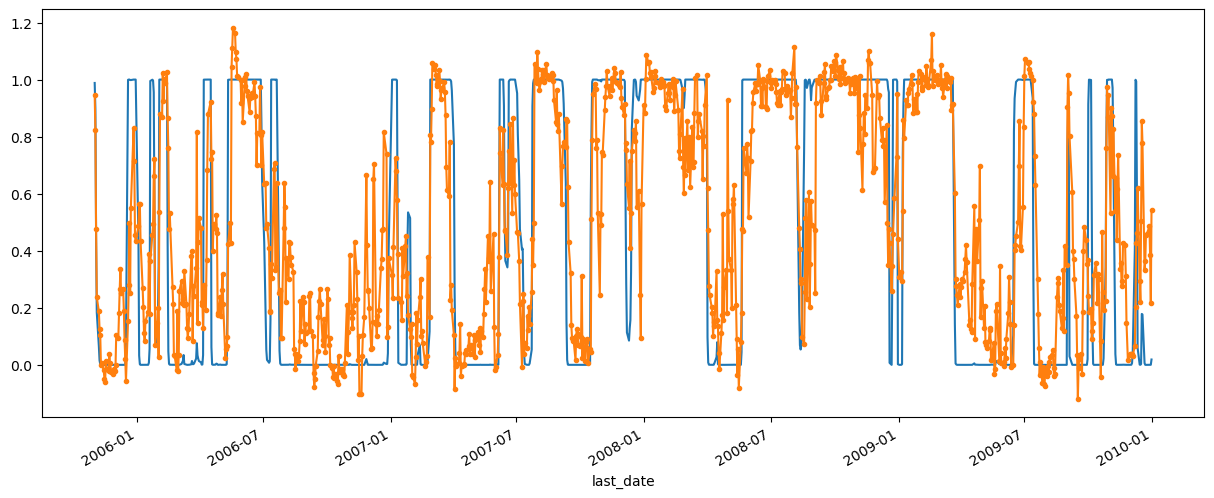

In [56]:
# Visualize both the val_y and y_preds to check accuracy
plt.figure(figsize=(15, 6))
val_y.plot(ax=plt.gca())
y_preds.plot(ax=plt.gca(), legend=None, marker=".");

# We can see clearly that the LightGBM trained on just the time-series features derived from the last 20 1M_RETURNS is still able to predict roughly similar patterns of bull/bear regimes as the HMM model.

In [57]:
# Print out all the selected X features

selected_X_features = []
for col in train_X_selected.columns:
    print(col)
    selected_X_features.append(col)
    
    
# Below are the most informative 249 features derived from just the last 20 daily periods of 1M_RETURNS

1M_RETURNS__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)
1M_RETURNS__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)
1M_RETURNS__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)
1M_RETURNS__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)
1M_RETURNS__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)
1M_RETURNS__minimum
1M_RETURNS__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)
1M_RETURNS__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)
1M_RETURNS__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"
1M_RETURNS__range_count__max_1000000000000.0__min_0
1M_RETURNS__count_below__t_0
1M_RETURNS__count_above__t_0
1M_RETURNS__range_count__max_0__min_-1000000000000.0
1M_RETURNS__quantile__q_0.1
1M_RETURNS__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)
1M_RETURNS__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"
1M_RETURNS__quantile__q_0.2
1M_RETURNS__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"
1M_RETU

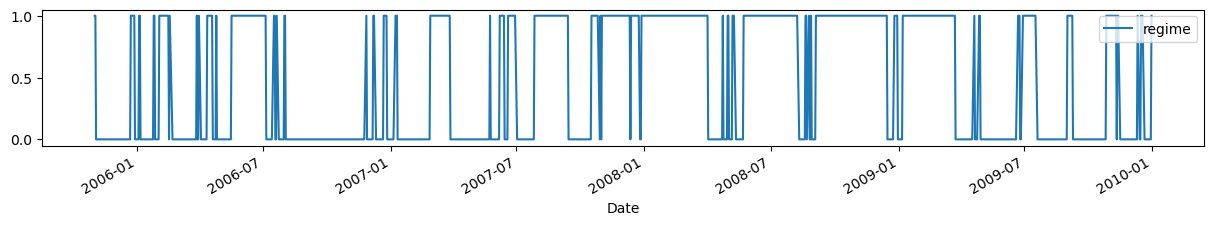

In [58]:
# Convert y_preds to binary labels for visualization
binary_y_preds = np.where(y_preds > 0.5, 1.0, 0.0)
val_y_preds = pd.DataFrame(binary_y_preds, index=val_y.index, columns=['regime'])

plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]

val_y_preds.plot(label= 'Bear proba Test Series')
plt.legend();

In [59]:
def create_tsfeatures(asset_df, symbol):
    """
    This function simply encapsulates all previous steps to create the timeseries features required from the 1M_RETURNS series
    
    :asset_df -> passed in need to have the column '1M_RETURNS' and requires a minimum of 20 rows
    :symbol -> ticker of asset in caps
    """
    # data preprocessing to create rolling windows for timeseries feature extraction
    returns = asset_df[['1M_RETURNS']].copy()
    returns['symbol'] = symbol
    returns['date'] = asset_df.index
    
    returns_rolled = roll_time_series(returns, column_sort='date', column_id='symbol', max_timeshift=20, min_timeshift=5)
    
    # extract timeseries features from each 20-period window
    extraction_settings = ComprehensiveFCParameters()
    X = extract_features(returns_rolled.drop('symbol', axis=1),
                            column_id='id', column_sort='date', column_value='1M_RETURNS',
                                impute_function=impute)
            
    # reindex to a datetimeindex
    X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
    X.index.name = 'last_date'
    
    # using the same set of X features as those fitted by the LightGBM model
    selected_X_features = ['1M_RETURNS__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__minimum',
                        '1M_RETURNS__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"',
                        '1M_RETURNS__range_count__max_1000000000000.0__min_0',
                        '1M_RETURNS__count_below__t_0',
                        '1M_RETURNS__count_above__t_0',
                        '1M_RETURNS__range_count__max_0__min_-1000000000000.0',
                        '1M_RETURNS__quantile__q_0.1',
                        '1M_RETURNS__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__quantile__q_0.2',
                        '1M_RETURNS__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"',
                        '1M_RETURNS__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"',
                        '1M_RETURNS__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__mean',
                        '1M_RETURNS__fft_coefficient__attr_"real"__coeff_0',
                        '1M_RETURNS__sum_values',
                        '1M_RETURNS__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"',
                        '1M_RETURNS__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"',
                        '1M_RETURNS__quantile__q_0.3',
                        '1M_RETURNS__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"',
                        '1M_RETURNS__quantile__q_0.4',
                        '1M_RETURNS__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__linear_trend__attr_"rvalue"',
                        '1M_RETURNS__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"',
                        '1M_RETURNS__friedrich_coefficients__coeff_3__m_3__r_30',
                        '1M_RETURNS__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"',
                        '1M_RETURNS__median',
                        '1M_RETURNS__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"',
                        '1M_RETURNS__mean_change',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0',
                        '1M_RETURNS__c3__lag_3',
                        '1M_RETURNS__quantile__q_0.6',
                        '1M_RETURNS__c3__lag_2',
                        '1M_RETURNS__c3__lag_1',
                        '1M_RETURNS__linear_trend__attr_"slope"',
                        '1M_RETURNS__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"',
                        '1M_RETURNS__quantile__q_0.7',
                        '1M_RETURNS__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0',
                        '1M_RETURNS__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"',
                        '1M_RETURNS__last_location_of_minimum',
                        '1M_RETURNS__first_location_of_minimum',
                        '1M_RETURNS__quantile__q_0.8',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2',
                        '1M_RETURNS__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__fft_coefficient__attr_"imag"__coeff_1',
                        '1M_RETURNS__quantile__q_0.9',
                        '1M_RETURNS__time_reversal_asymmetry_statistic__lag_1',
                        '1M_RETURNS__time_reversal_asymmetry_statistic__lag_2',
                        '1M_RETURNS__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__fft_coefficient__attr_"imag"__coeff_2',
                        '1M_RETURNS__time_reversal_asymmetry_statistic__lag_3',
                        '1M_RETURNS__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__maximum',
                        '1M_RETURNS__max_langevin_fixed_point__m_3__r_30',
                        '1M_RETURNS__fft_coefficient__attr_"imag"__coeff_3',
                        '1M_RETURNS__fft_coefficient__attr_"real"__coeff_10',
                        '1M_RETURNS__fft_coefficient__attr_"real"__coeff_9',
                        '1M_RETURNS__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"',
                        '1M_RETURNS__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__fft_coefficient__attr_"real"__coeff_8',
                        '1M_RETURNS__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0',
                        '1M_RETURNS__fft_coefficient__attr_"imag"__coeff_4',
                        '1M_RETURNS__fft_coefficient__attr_"real"__coeff_7',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4',
                        '1M_RETURNS__fft_coefficient__attr_"angle"__coeff_0',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2',
                        '1M_RETURNS__fft_coefficient__attr_"real"__coeff_6',
                        '1M_RETURNS__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__fft_coefficient__attr_"angle"__coeff_1',
                        '1M_RETURNS__fft_coefficient__attr_"imag"__coeff_5',
                        '1M_RETURNS__first_location_of_maximum',
                        '1M_RETURNS__last_location_of_maximum',
                        '1M_RETURNS__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__fft_coefficient__attr_"imag"__coeff_6',
                        '1M_RETURNS__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__fft_coefficient__attr_"angle"__coeff_2',
                        '1M_RETURNS__fft_coefficient__attr_"real"__coeff_5',
                        '1M_RETURNS__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"',
                        '1M_RETURNS__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2',
                        '1M_RETURNS__fft_coefficient__attr_"angle"__coeff_3',
                        '1M_RETURNS__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__fft_coefficient__attr_"real"__coeff_4',
                        '1M_RETURNS__fft_coefficient__attr_"imag"__coeff_7',
                        '1M_RETURNS__fft_coefficient__attr_"angle"__coeff_4',
                        '1M_RETURNS__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"',
                        '1M_RETURNS__fft_coefficient__attr_"angle"__coeff_5',
                        '1M_RETURNS__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0',
                        '1M_RETURNS__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2',
                        '1M_RETURNS__fft_coefficient__attr_"angle"__coeff_6',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0',
                        '1M_RETURNS__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2',
                        '1M_RETURNS__number_cwt_peaks__n_5',
                        '1M_RETURNS__friedrich_coefficients__coeff_1__m_3__r_30',
                        '1M_RETURNS__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__variance',
                        '1M_RETURNS__standard_deviation',
                        '1M_RETURNS__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0',
                        '1M_RETURNS__fft_coefficient__attr_"imag"__coeff_8',
                        '1M_RETURNS__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0',
                        '1M_RETURNS__mean_abs_change',
                        '1M_RETURNS__fft_coefficient__attr_"real"__coeff_3',
                        '1M_RETURNS__absolute_sum_of_changes',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2',
                        '1M_RETURNS__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"',
                        '1M_RETURNS__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2',
                        '1M_RETURNS__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0',
                        '1M_RETURNS__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0',
                        '1M_RETURNS__cid_ce__normalize_False',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2',
                        '1M_RETURNS__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0',
                        '1M_RETURNS__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0',
                        '1M_RETURNS__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2',
                        '1M_RETURNS__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"',
                        '1M_RETURNS__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4',
                        '1M_RETURNS__fft_aggregated__aggtype_"centroid"',
                        '1M_RETURNS__linear_trend__attr_"stderr"',
                        '1M_RETURNS__fft_coefficient__attr_"angle"__coeff_7',
                        '1M_RETURNS__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4',
                        '1M_RETURNS__fft_aggregated__aggtype_"skew"',
                        '1M_RETURNS__number_crossing_m__m_0',
                        '1M_RETURNS__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__energy_ratio_by_chunks__num_segments_10__segment_focus_9',
                        '1M_RETURNS__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0',
                        '1M_RETURNS__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"',
                        '1M_RETURNS__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4',
                        '1M_RETURNS__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2',
                        '1M_RETURNS__fft_aggregated__aggtype_"variance"',
                        '1M_RETURNS__fft_coefficient__attr_"abs"__coeff_10',
                        '1M_RETURNS__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0',
                        '1M_RETURNS__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"',
                        '1M_RETURNS__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2',
                        '1M_RETURNS__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"',
                        '1M_RETURNS__fft_coefficient__attr_"abs"__coeff_3',
                        '1M_RETURNS__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0',
                        '1M_RETURNS__fft_coefficient__attr_"abs"__coeff_9',
                        '1M_RETURNS__index_mass_quantile__q_0.9',
                        '1M_RETURNS__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"',
                        '1M_RETURNS__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4',
                        '1M_RETURNS__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"',
                        '1M_RETURNS__fft_coefficient__attr_"angle"__coeff_8',
                        '1M_RETURNS__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"',
                        '1M_RETURNS__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__index_mass_quantile__q_0.8',
                        '1M_RETURNS__fft_coefficient__attr_"abs"__coeff_1',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8',
                        '1M_RETURNS__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2',
                        '1M_RETURNS__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"',
                        '1M_RETURNS__energy_ratio_by_chunks__num_segments_10__segment_focus_8',
                        '1M_RETURNS__index_mass_quantile__q_0.7',
                        '1M_RETURNS__fft_coefficient__attr_"abs"__coeff_2',
                        '1M_RETURNS__fft_coefficient__attr_"abs"__coeff_8',
                        '1M_RETURNS__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"',
                        '1M_RETURNS__fft_coefficient__attr_"abs"__coeff_4',
                        '1M_RETURNS__index_mass_quantile__q_0.6',
                        '1M_RETURNS__fft_coefficient__attr_"abs"__coeff_5',
                        '1M_RETURNS__fft_coefficient__attr_"imag"__coeff_9',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6',
                        '1M_RETURNS__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"',
                        '1M_RETURNS__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4',
                        '1M_RETURNS__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8',
                        '1M_RETURNS__fft_coefficient__attr_"real"__coeff_2',
                        '1M_RETURNS__fft_coefficient__attr_"abs"__coeff_7',
                        '1M_RETURNS__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6',
                        '1M_RETURNS__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2',
                        '1M_RETURNS__variation_coefficient',
                        '1M_RETURNS__spkt_welch_density__coeff_2',
                        '1M_RETURNS__index_mass_quantile__q_0.4',
                        '1M_RETURNS__fft_coefficient__attr_"abs"__coeff_6',
                        '1M_RETURNS__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6',
                        '1M_RETURNS__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__friedrich_coefficients__coeff_2__m_3__r_30',
                        '1M_RETURNS__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8',
                        '1M_RETURNS__fft_coefficient__attr_"angle"__coeff_9',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4',
                        '1M_RETURNS__spkt_welch_density__coeff_5',
                        '1M_RETURNS__fft_aggregated__aggtype_"kurtosis"',
                        '1M_RETURNS__index_mass_quantile__q_0.3',
                        '1M_RETURNS__energy_ratio_by_chunks__num_segments_10__segment_focus_7',
                        '1M_RETURNS__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"',
                        '1M_RETURNS__partial_autocorrelation__lag_4',
                        '1M_RETURNS__permutation_entropy__dimension_5__tau_1',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6',
                        '1M_RETURNS__partial_autocorrelation__lag_3',
                        '1M_RETURNS__agg_autocorrelation__f_agg_"var"__maxlag_40',
                        '1M_RETURNS__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__friedrich_coefficients__coeff_0__m_3__r_30',
                        '1M_RETURNS__spkt_welch_density__coeff_8',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2',
                        '1M_RETURNS__index_mass_quantile__q_0.2',
                        '1M_RETURNS__permutation_entropy__dimension_6__tau_1',
                        '1M_RETURNS__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0',
                        '1M_RETURNS__fft_coefficient__attr_"abs"__coeff_0',
                        '1M_RETURNS__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0',
                        '1M_RETURNS__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6',
                        '1M_RETURNS__benford_correlation',
                        '1M_RETURNS__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"',
                        '1M_RETURNS__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8',
                        '1M_RETURNS__ratio_beyond_r_sigma__r_1',
                        '1M_RETURNS__symmetry_looking__r_0.05',
                        '1M_RETURNS__skewness',
                        '1M_RETURNS__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"',
                        '1M_RETURNS__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__permutation_entropy__dimension_4__tau_1',
                        '1M_RETURNS__energy_ratio_by_chunks__num_segments_10__segment_focus_1',
                        '1M_RETURNS__cid_ce__normalize_True',
                        '1M_RETURNS__ratio_value_number_to_time_series_length',
                        '1M_RETURNS__percentage_of_reoccurring_values_to_all_values',
                        '1M_RETURNS__has_duplicate',
                        '1M_RETURNS__percentage_of_reoccurring_datapoints_to_all_datapoints',
                        '1M_RETURNS__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)',
                        '1M_RETURNS__energy_ratio_by_chunks__num_segments_10__segment_focus_2',
                        '1M_RETURNS__linear_trend__attr_"intercept"',
                        '1M_RETURNS__mean_second_derivative_central',
                        '1M_RETURNS__longest_strike_below_mean',
                        '1M_RETURNS__energy_ratio_by_chunks__num_segments_10__segment_focus_0']
    
    
    selected_X = X[selected_X_features]
    return selected_X


In [60]:
# Create timeseries features for testing period between 2010-2023/1
tt = create_tsfeatures(test_df, 'SPY')
tt

Feature Extraction: 100%|██████████| 20/20 [01:15<00:00,  3.76s/it]


,"1M_RETURNS__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)","1M_RETURNS__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)","1M_RETURNS__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)","1M_RETURNS__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)","1M_RETURNS__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)",1M_RETURNS__minimum,"1M_RETURNS__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)","1M_RETURNS__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)","1M_RETURNS__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""min""",1M_RETURNS__range_count__max_1000000000000.0__min_0,...,1M_RETURNS__ratio_value_number_to_time_series_length,1M_RETURNS__percentage_of_reoccurring_values_to_all_values,1M_RETURNS__has_duplicate,1M_RETURNS__percentage_of_reoccurring_datapoints_to_all_datapoints,"1M_RETURNS__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)",1M_RETURNS__energy_ratio_by_chunks__num_segments_10__segment_focus_2,"1M_RETURNS__linear_trend__attr_""intercept""",1M_RETURNS__mean_second_derivative_central,1M_RETURNS__longest_strike_below_mean,1M_RETURNS__energy_ratio_by_chunks__num_segments_10__segment_focus_0
last_date,,,,,,,,,,,,,,,,,,,,,
2010-01-11,0.051969,0.026195,0.049219,0.053545,0.051554,0.024181,0.054628,0.054029,1.000000,6.0,...,1.0,0.0,0.0,0.0,0.028705,0.099892,0.024858,-0.001657,4.0,0.065608
2010-01-12,0.051969,0.026195,0.049219,0.053545,0.051554,0.024181,0.054628,0.054029,1.000000,7.0,...,1.0,0.0,0.0,0.0,0.038540,0.089117,0.028787,-0.002640,4.0,0.058531
2010-01-13,0.051969,0.026195,0.049219,0.053545,0.051554,0.024181,0.054628,0.054029,1.000000,8.0,...,1.0,0.0,0.0,0.0,0.034243,0.078302,0.030472,-0.000541,4.0,0.051429
2010-01-14,0.051969,0.026195,0.049219,0.053545,0.051554,0.024181,0.054628,0.054029,1.000000,9.0,...,1.0,0.0,0.0,0.0,0.043699,0.071502,0.032331,-0.001076,4.0,0.046962
2010-01-15,0.051969,0.026195,0.049219,0.053545,0.051554,0.024181,0.054628,0.054029,1.000000,10.0,...,1.0,0.0,0.0,0.0,0.036744,0.067803,0.034551,-0.001102,3.0,0.044533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-23,-0.012342,0.029335,-0.028240,-0.027099,-0.037895,-0.060904,-0.043092,-0.047425,0.916520,6.0,...,1.0,0.0,0.0,0.0,-0.018348,0.151669,-0.058794,0.000999,10.0,0.157778
2023-01-24,0.006130,0.040907,-0.013285,-0.008382,-0.022451,-0.060904,-0.024505,-0.032456,0.931209,7.0,...,1.0,0.0,0.0,0.0,-0.035772,0.258739,-0.063052,-0.000424,9.0,0.225173
2023-01-25,0.026727,0.052775,0.001912,0.011775,-0.005032,-0.060904,-0.004685,-0.014697,0.964098,8.0,...,1.0,0.0,0.0,0.0,-0.043328,0.231724,-0.062765,0.000499,9.0,0.221145


In [66]:
def create_predictions(trained_model, X_features_df):
    y_preds = pd.Series(trained_model.predict(X_features_df), index=X_features_df.index)
    # Convert y_preds to binary labels for visualization
    binary_y_preds = np.where(y_preds > 0.5, 1.0, 0.0)
    binary_y_preds = pd.DataFrame(binary_y_preds, index=X_features_df.index, columns=['regime'])
    binary_y_preds.index.name = 'Date'   # rename 'last_date' to 'Date'
    return binary_y_preds


tt_preds = create_predictions(model_tsf, tt)

# Likewise, Shift all the regime preds by +1 period for backtesting on yesterday's signals, and not today's signals
tt_preds['regime'] = tt_preds['regime'].shift(1)
tt_preds.to_csv('regime_filter.csv', index=True)


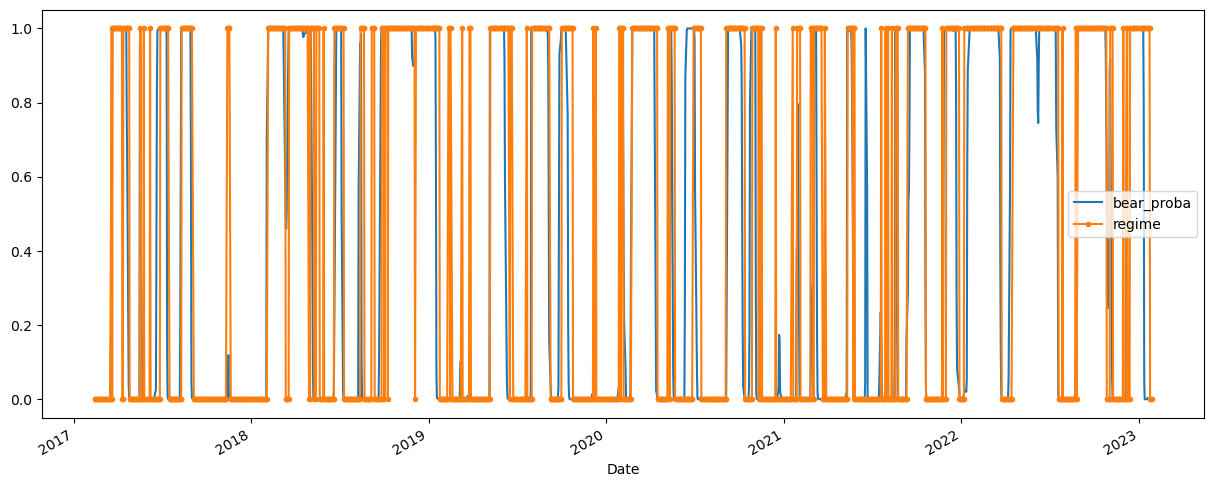

In [67]:
# Visualize both the val_y and y_preds to check accuracy
plt.figure(figsize=(15, 6))
test_df['bear_proba'][-1500:].plot(ax=plt.gca())
tt_preds[-1500:].plot(ax=plt.gca(), legend=None, marker=".");
plt.legend();


## Backtesting Profitability for Test Period 2018-2023/1

### 1. Regime Prediction using Hidden Markov model-generated log-probabilities (One-Step Ahead)

In [68]:
# Read in backtest results csv file
filepath = f'./datasets/backtest_results/LGBM_market_regimes_predictions_backtest_with_HMM_bear_proba.csv'
backtest = pd.read_csv(filepath)

backtest.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
backtest['Date'] = pd.to_datetime(backtest.Date)
backtest.set_index('Date', inplace=True)
backtest

,OPEN,HIGH,LOW,CLOSE,ADJ CLOSE,VOLUME,forecast,ideal_pos,close,fill_size,fill_price,total_buy,total_sell,average_buy_price,average_sell_price,unrealized_pnl,realized_pnl,total_pnl
Date,,,,,,,,,,,,,,,,,,
2018-01-02,267.839996,268.809998,267.399994,268.769989,246.766617,86655700.0,0,0,246.766617,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-03,268.959991,270.640015,268.959991,270.470001,248.327469,90070400.0,-10,-405,248.327469,-405,248.327469,0,-405,0.000000,248.327469,-0.000000,0.000000,0.000000
2018-01-04,271.200012,272.160004,270.540009,271.609985,249.374069,80636400.0,-10,-402,249.374069,0,0.000000,0,-405,0.000000,248.327469,-423.873138,0.000000,-423.873138
2018-01-05,272.510010,273.559998,271.950012,273.420013,251.035965,83524000.0,-10,-399,251.035965,0,0.000000,0,-405,0.000000,248.327469,-1096.940918,0.000000,-1096.940918
2018-01-08,273.309998,274.100006,272.980011,273.920013,251.495087,57319200.0,-10,-393,251.495087,0,0.000000,0,-405,0.000000,248.327469,-1282.885208,0.000000,-1282.885208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-23,396.720001,402.649994,395.720001,400.630005,400.630005,84178800.0,-10,-214,400.630005,0,0.000000,17473,-17685,328.485991,328.448888,-15302.396758,-648.298372,-15950.695129
2023-01-24,398.880005,401.149994,397.640015,400.200012,400.200012,59524900.0,-10,-209,400.200012,0,0.000000,17473,-17685,328.485991,328.448888,-15211.238311,-648.298372,-15859.536682
2023-01-25,395.950012,400.700012,393.559998,400.350006,400.350006,84800300.0,-10,-210,400.350006,0,0.000000,17473,-17685,328.485991,328.448888,-15243.037017,-648.298372,-15891.335388


Start date,2018-01-02
End date,2023-01-27
Total months,60
,Backtest
Annual return,-3.6%
Cumulative returns,-17.0%
Annual volatility,21.2%
Sharpe ratio,-0.07
Calmar ratio,-0.10
Stability,0.39
Max drawdown,-37.7%


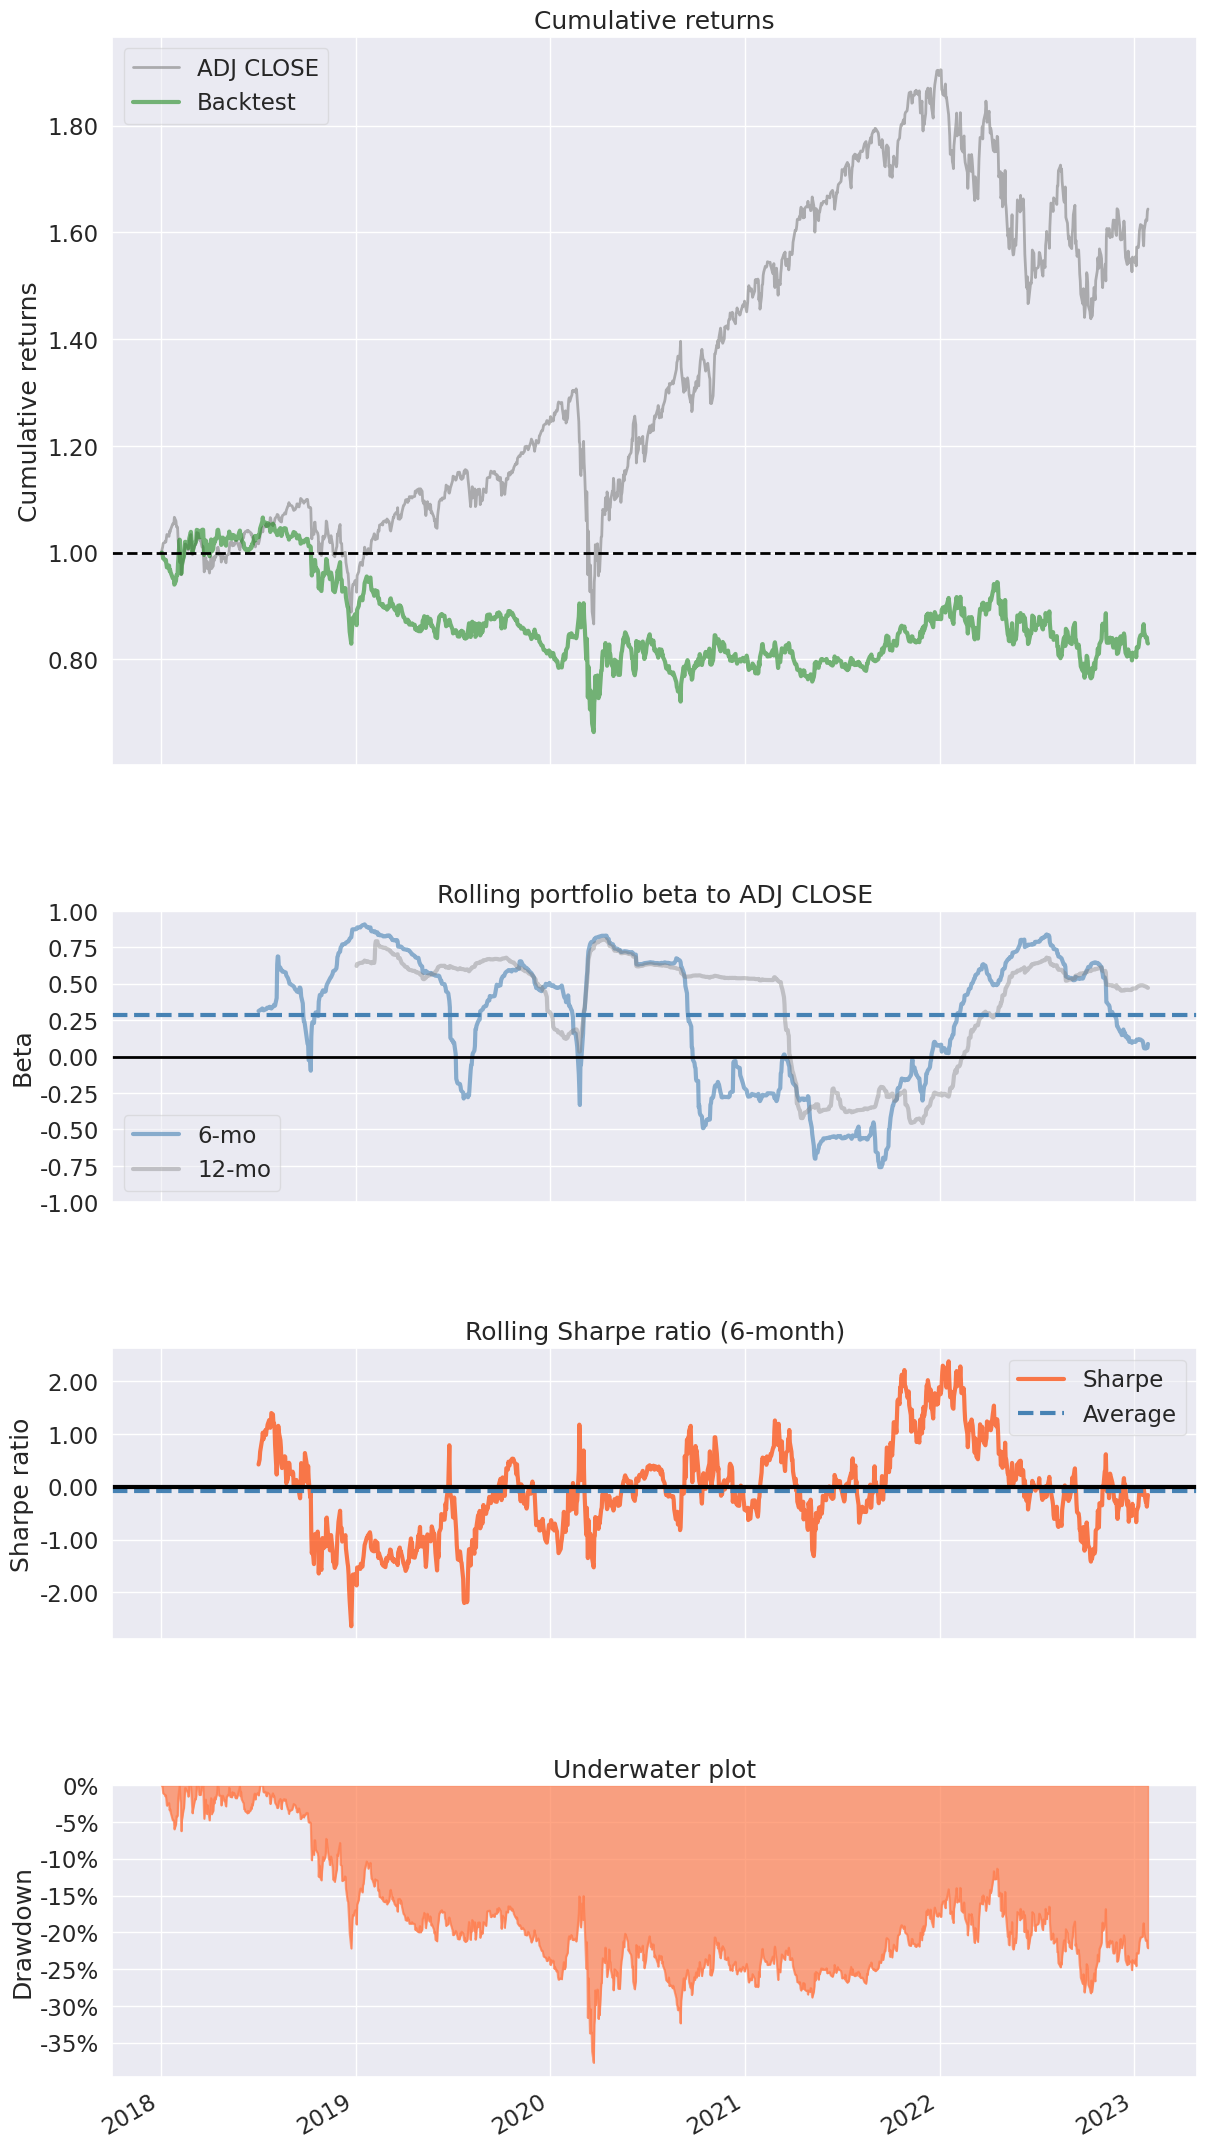

In [69]:
# Create benchmark daily returns for tearsheet analysis
def get_daily_returns(pnl_series, initial_capital):
    df = pnl_series.to_frame()
    df['cum_returns'] = df / initial_capital + 1
    df['daily_returns'] = df['cum_returns'].pct_change()
    return df['daily_returns']


spy_returns = backtest['ADJ CLOSE'].pct_change()
benchmark=spy_returns

initial_capital = 100_000   # used US$100,000 starting capital in my backtester program
#need to align mainsystem.portfolio_pnl index with spy returns index for benchmark_rets to work
returns=get_daily_returns(backtest['total_pnl'], initial_capital)[spy_returns.index]

# Create tearsheet
pyf.tears.create_simple_tear_sheet(returns, benchmark_rets=benchmark)

### 2. Regime Prediction using timeseries features derived from 1M_RETURNS

In [70]:
# Read in backtest results csv file
filepath = f'./datasets/backtest_results/LGBM_market_regimes_predictions_backtest_with_1M_RETURNS_tsf.csv'
backtest = pd.read_csv(filepath)

backtest.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
backtest['Date'] = pd.to_datetime(backtest.Date)
backtest.set_index('Date', inplace=True)
backtest

,OPEN,HIGH,LOW,CLOSE,ADJ CLOSE,VOLUME,forecast,ideal_pos,close,fill_size,fill_price,total_buy,total_sell,average_buy_price,average_sell_price,unrealized_pnl,realized_pnl,total_pnl
Date,,,,,,,,,,,,,,,,,,
2018-01-02,267.839996,268.809998,267.399994,268.769989,246.766617,86655700.0,10,0,246.766617,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-03,268.959991,270.640015,268.959991,270.470001,248.327469,90070400.0,10,405,248.327469,405,248.327469,405,0,248.327469,0.000000,0.000000,-0.000000,0.000000
2018-01-04,271.200012,272.160004,270.540009,271.609985,249.374069,80636400.0,10,402,249.374069,0,0.000000,405,0,248.327469,0.000000,423.873138,-0.000000,423.873138
2018-01-05,272.510010,273.559998,271.950012,273.420013,251.035965,83524000.0,10,402,251.035965,0,0.000000,405,0,248.327469,0.000000,1096.940918,-0.000000,1096.940918
2018-01-08,273.309998,274.100006,272.980011,273.920013,251.495087,57319200.0,10,402,251.495087,0,0.000000,405,0,248.327469,0.000000,1282.885208,-0.000000,1282.885208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-23,396.720001,402.649994,395.720001,400.630005,400.630005,84178800.0,-10,-224,400.630005,0,0.000000,33609,-33831,313.868276,314.082237,-19213.604472,7190.998621,-12022.605850
2023-01-24,398.880005,401.149994,397.640015,400.200012,400.200012,59524900.0,10,219,400.200012,441,400.200012,34050,-33831,314.986406,314.082237,18661.779852,-30588.927329,-11927.147476
2023-01-25,395.950012,400.700012,393.559998,400.350006,400.350006,84800300.0,10,220,400.350006,0,0.000000,34050,-33831,314.986406,314.082237,18694.628516,-30588.927329,-11894.298813


Start date,2018-01-02
End date,2023-01-27
Total months,60
,Backtest
Annual return,-2.2%
Cumulative returns,-10.7%
Annual volatility,18.9%
Sharpe ratio,-0.02
Calmar ratio,-0.06
Stability,0.41
Max drawdown,-40.2%


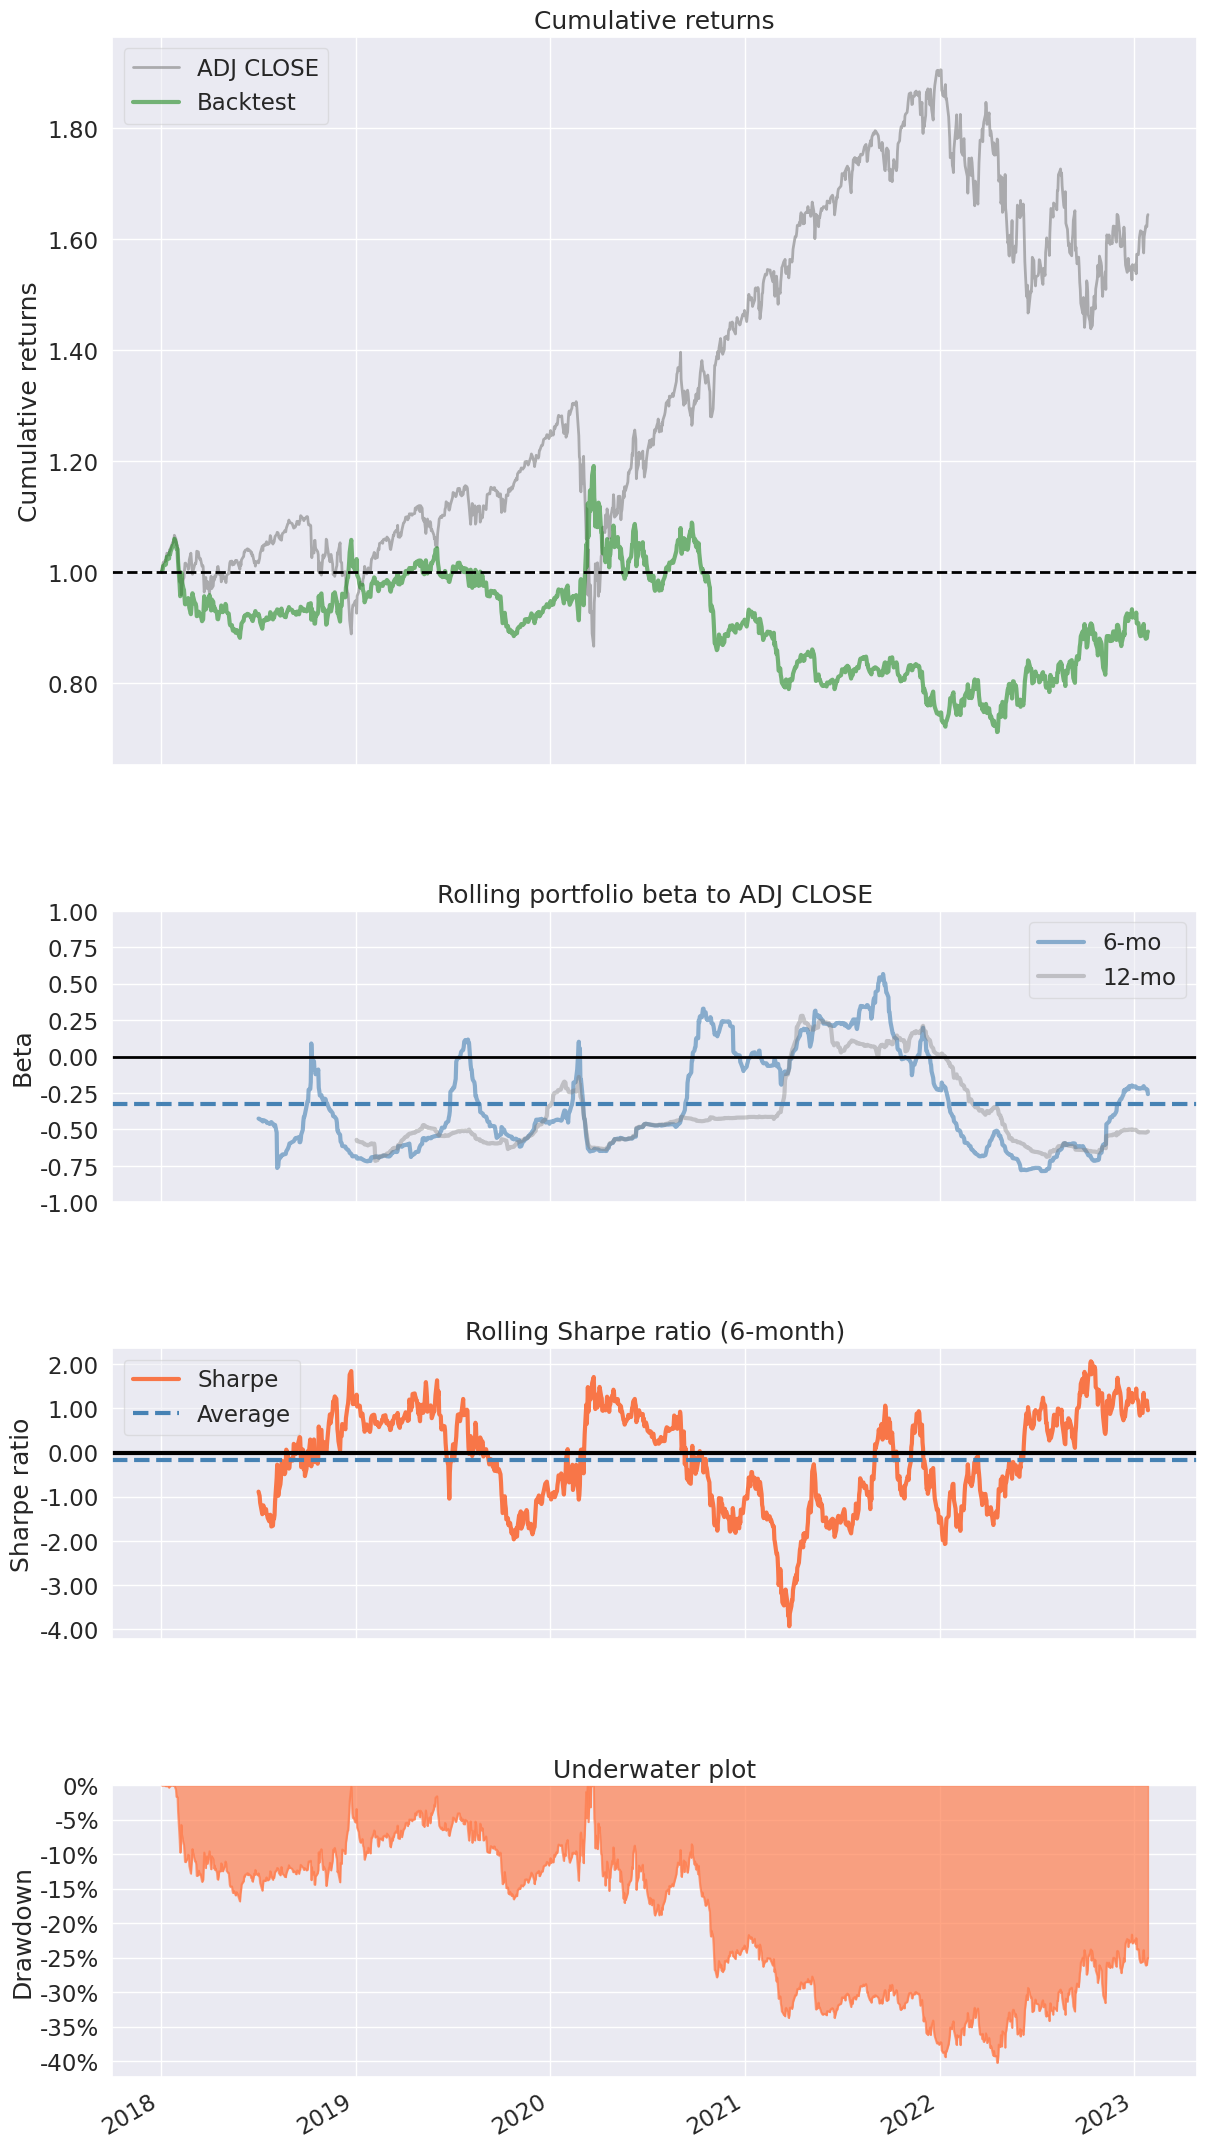

In [71]:
# Create benchmark daily returns for tearsheet analysis
def get_daily_returns(pnl_series, initial_capital):
    df = pnl_series.to_frame()
    df['cum_returns'] = df / initial_capital + 1
    df['daily_returns'] = df['cum_returns'].pct_change()
    return df['daily_returns']


spy_returns = backtest['ADJ CLOSE'].pct_change()
benchmark=spy_returns

initial_capital = 100_000   # used US$100,000 starting capital in my backtester program
#need to align mainsystem.portfolio_pnl index with spy returns index for benchmark_rets to work
returns=get_daily_returns(backtest['total_pnl'], initial_capital)[spy_returns.index]

# Create tearsheet
pyf.tears.create_simple_tear_sheet(returns, benchmark_rets=benchmark)